In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
from detectron2.utils.logger import setup_logger
setup_logger()

import os, sys
home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
home_dir = os.path.abspath(os.getcwd())
sys.path.append(home_dir)
print(home_dir)

from utils.arguments import load_vcoco_opt_command
from utils.distributed import init_distributed

/home/djjin/Mygit/X-Decoder/notebooks


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
opt, cmdline_args = load_vcoco_opt_command(home_dir)
opt = init_distributed(opt)

In [4]:
# from datasets.registration.register_vcoco_dataset import register_all_vcoco
# _root = os.getenv("DATASET", "../datasets")
# register_all_vcoco(_root)

In [5]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[07/31 22:55:42 d2.data.common]: Serializing 5400 elements to byte tensors and concatenating them all ...
[07/31 22:55:42 d2.data.common]: Serialized dataset takes 3.62 MiB


In [6]:
for dataloader, dataset_name in zip(train_data_loader, dataset_names):
    print(dataloader)

{'vcoco': [{'id': 4418, 'file_name': '../datasets/v-coco/images/train2014/COCO_train2014_000000329386.jpg', 'hoi_annotation': [{'subject_id': 20, 'category_id': 2, 'object_id': -1}, {'subject_id': 20, 'category_id': 8, 'object_id': 14}, {'subject_id': 20, 'category_id': 9, 'object_id': -1}, {'subject_id': 20, 'category_id': 23, 'object_id': -1}], 'annotations': [{'category_id': 32, 'bbox': [180.96, 135.66, 183.59, 141.79]}, {'category_id': 62, 'bbox': [388.76, 199.38, 459.18, 316.37]}, {'category_id': 62, 'bbox': [501.65, 195.8, 574.29, 290.9]}, {'category_id': 62, 'bbox': [594.66, 202.3, 640.0, 298.9]}, {'category_id': 62, 'bbox': [0.0, 205.66, 158.69, 346.62]}, {'category_id': 62, 'bbox': [58.19, 196.92, 114.24, 236.75]}, {'category_id': 62, 'bbox': [395.48, 181.3, 444.72, 259.95000000000005]}, {'category_id': 62, 'bbox': [356.9, 187.3, 388.0, 240.16000000000003]}, {'category_id': 67, 'bbox': [4.3, 344.52, 640.0, 473.66999999999996]}, {'category_id': 1, 'bbox': [449.62, 145.57, 509.7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


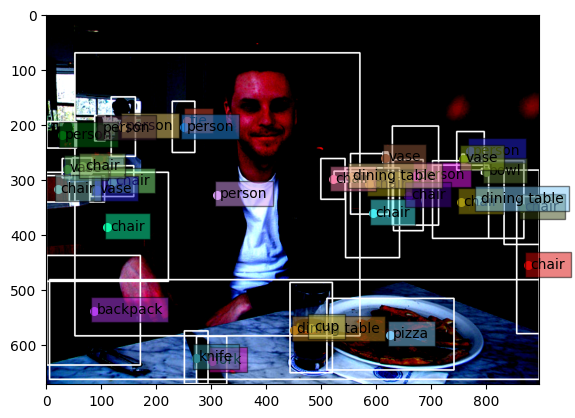

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


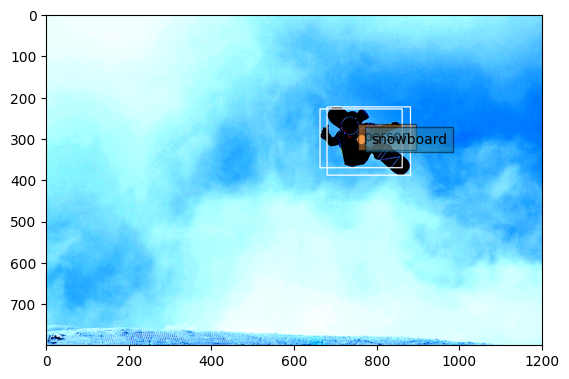

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


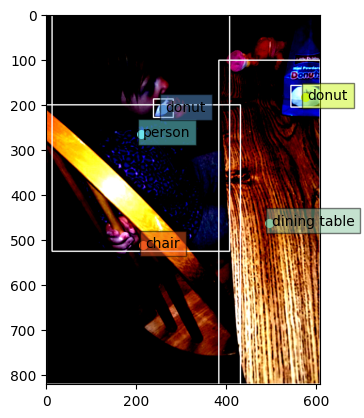

In [7]:
import cv2, random
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for test in batch:
                target_img = test["image"]
                target = test["instances"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                hh, ww = img.shape[0], img.shape[1]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                obj_labels = []
                labels = []
                verb_names = []
                ob_boxes = []
                sub_boxes = []

                obj_boxes = target['boxes']
                for test in range(obj_boxes.shape[0]):
                    cx, cy, w, h = obj_boxes[test]
                    color = random_color()
                    cx, cy, w, h = cx * ww, cy * hh, w * ww, h * hh
                    n_box = list(map(int, [cx - 0.5 * w, cy - 0.5 * h, cx + 0.5 * w, cy + 0.5 * h]))
                    x1, y1, x2, y2 = n_box
                    ob_boxes.append(n_box)
                    
                for idx in target['labels']:
                    label_name = get_coco_instance_ID_to_name(valid_obj_ids[idx])
                    labels.append(label_name)

                for label, box in zip(labels, ob_boxes):
                    color = random_color()
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    plt.text(
                        x + 5,
                        y + 5,
                        label,
                        fontsize=10,
                        bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                        )

                plt.imshow(img)
                plt.show()